In [ ]:
!pip install contractions
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pickle
import numpy as np
import nltk
import re
import keras
import contractions

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag

import string
import contractions
import spacy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
#remove contractions
def fix_contractions(tweets):
  no_contract = []
  for item in range(len(tweets)):
    try:
      no_contract.append(contractions.fix(tweets[item]))
    except IndexError:
      pass
  return no_contract

In [ ]:
def remove_noise(tweet_tokens):
    # remove hyperlinks, special characters, emojis, punctuations
    
    for i in range(len(tweet_tokens)):
        tweet_tokens[i] = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                           '(?:%[0-9a-fA-F][0-9a-fA-F]))*', ' ', tweet_tokens[i])
        # Remove twitter handles
        tweet_tokens[i] = re.sub("(@[A-Za-z0-9_]*)"," ", tweet_tokens[i])
        # make lower
        tweet_tokens[i] = tweet_tokens[i].lower()
        tweet_tokens[i] = re.sub('\brt\b', ' ', tweet_tokens[i])
        tweet_tokens[i] = re.sub('[^\w\s]', ' ', tweet_tokens[i])
    return tweet_tokens

In [ ]:
def tokenise(tweet):
  tokenizer = RegexpTokenizer(r'\w+|[^\w\s]+')
  tokenized = [tokenizer.tokenize(each) for each in tweet]
  return tokenized

In [ ]:
stop_words=set(stopwords.words('english'))
stop_words.remove('not')

In [ ]:
def remove_stopwords(X):
  X_without_stopwords = []
  for sentence in X:
    temp = [word for word in sentence if not word in stop_words]
    X_without_stopwords.append(temp) 

  return X_without_stopwords

In [ ]:
def lemmatize(tweet):
  #Lemmatization
  nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'ner'])    

  lengths = np.cumsum([0] + list(map(len, tweet)))

  flat_words = [item for sublist in tweet for item in sublist]
  doc = spacy.tokens.Doc(nlp.vocab, words=flat_words)

  lemmatized = []
  # Iterate starting with 1
  for index in range(1, len(lengths)):
      # Slice doc as described in the first point, so [0:3] and [3:6]
      span = doc[lengths[index - 1] : lengths[index]]
      # Add lemmatized tokens as list to the list
      lemmatized.append([token.lemma_ for token in span])

  return lemmatized

In [ ]:
def clean_vec_pad(tweet):
  clean_lem = []

  for sentence in tweet:
    temp = " ".join(sentence)
    clean_lem.append(temp)

  ltcleanvectorized=tokenizer.texts_to_sequences(clean_lem)

  ltcleanpad = pad_sequences(ltcleanvectorized, max_length,padding='post',
                                                         truncating='post')
  
  return ltcleanpad


In [ ]:
with open('/content/drive/MyDrive/newtokenizer.pickle', 'rb') as handle:
  tokenizer = pickle.load(handle)

# only for confusion matrix, else not needed
with open('/content/drive/MyDrive/newfsacd_x_test.pickle', 'rb') as handle:
  X_test = pickle.load(handle)

with open('/content/drive/MyDrive/newfsacd_y_test.pickle', 'rb') as handle:
  Y_test = pickle.load(handle)

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/contract_newfsact_lstm2l_w_neu')

In [ ]:
max_length=25
labels = ["Negative", "Neutral", "Positive"]

In [ ]:
# prediction

def sentiment_predict(text):
  print(text)
  fc = fix_contractions(text)
  print(fc)
  rm = remove_noise(fc)
  print(rm)
  tk = tokenise(rm)
  print(tk)
  sw = remove_stopwords(tk)
  print(sw)
  lm = lemmatize(sw)
  print(lm)
  pd = clean_vec_pad(lm)
  return model.predict(pd)

  #predicted = model.predict(pd)

In [ ]:
test_text = ["Donald Trump is back!"]

In [ ]:
out = sentiment_predict(test_text)

['Donald Trump is back!']
['Donald Trump is back!']
['donald trump is back ']
[['donald', 'trump', 'is', 'back']]
[['donald', 'trump', 'back']]
[['donald', 'trump', 'back']]


In [ ]:
print(labels[np.argmax(out)])

Neutral


In [ ]:
ref = []
for test in Y_test:
  ref.append(test[0])

In [ ]:
y_preds = model.predict(X_test)

In [ ]:
test = []
for i in y_preds:
  test.append(np.argmax(i))

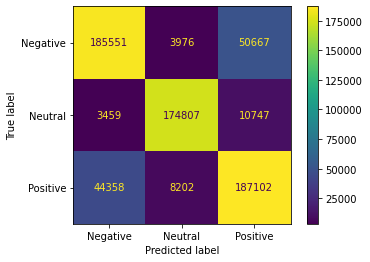

In [ ]:
# plot confusion matrix
cm = confusion_matrix(y_true = ref, y_pred=test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format='')

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
precision_recall_fscore_support(ref, test, labels=[0, 1, 2])

(array([0.79510044, 0.93487178, 0.75287708]),
 array([0.77250473, 0.92484115, 0.78069114]),
 array([0.78363973, 0.92982941, 0.76653188]),
 array([240194, 189013, 239662]))